# 성능개선
1. MBconv에서 SE 블록 대신 ECA 사용, Fused-MBconv에 ECA 추가

  -SE 블록은 Fully Connected 레이어를 사용하여 채널 중요도를 학습 ECA은 Fully Connected 대신 1D 컨볼루션을 사용해 간소화된 방식으로 채널 중요도를 더 효율적으로 학습.

  -SE는 더 정교한 채널 중요도를 학습할 수 있지만 계산 비용이 높음. ECA는 경량화되어 실시간 애플리케이션에 적합.

2. 평가

  test accuarcy : 88.47%

  Self CPU time total: 2.622s
  Self CUDA time total: 645.484ms

참고문헌 ECA-Net: Efficient channel attention for deep convolutional neural networks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터셋 다운로드, 라이브러리 불러오기

In [2]:
!kaggle datasets download alistairking/recyclable-and-household-waste-classification

Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification
License(s): MIT
 98% 899M/920M [00:04<00:00, 237MB/s]
100% 920M/920M [00:04<00:00, 231MB/s]


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import time

# EfficientnetV2 구현하기

In [4]:
Eff_V2_SETTINGS = {
    # expansion factor, kernel_size, stride, n_in, n_out, num_layers, use_fusedMBCONV
    's' : [
        [1, 3, 1, 24, 24, 2, True],
        [4, 3, 2, 24, 48, 4, True],
        [4, 3, 2, 48, 64, 4, True],
        [4, 3, 2, 64, 128, 6, False],
        [6, 3, 1, 128, 160, 9, False],
        [6, 3, 2, 160, 256, 15, False]
    ],

    'm' : [
        [1, 3, 1, 24, 24, 3, True],
        [4, 3, 2, 24, 48, 5, True],
        [4, 3, 2, 48, 80, 5, True],
        [4, 3, 2, 80, 160, 7, False],
        [6, 3, 1, 160, 176, 14, False],
        [6, 3, 2, 176, 304, 18, False],
        [6, 3, 1, 304, 512, 5, False]
    ],

    'l' : [
        [1, 3, 1, 32, 32, 4, True],
        [4, 3, 2, 32, 64, 7, True],
        [4, 3, 2, 64, 96, 7, True],
        [4, 3, 2, 96, 192, 10, False],
        [6, 3, 1, 192, 224, 19, False],
        [6, 3, 2, 224, 384, 25, False],
        [6, 3, 1, 384, 640, 7, False]
    ]
}

In [5]:
# simple Convolution + Batch Normalization + Activation Class
class ConvBnAct(nn.Module):

    def __init__(
        self,
        n_in, # in_channels
        n_out, # out_channels
        k_size = 3, # Kernel Size
        stride = 1,
        padding = 0,
        groups = 1,
        act = True,
        bn = True,
        bias = False,
        alpha = 0.01
    ):
        super(ConvBnAct, self).__init__()

        self.conv = nn.Conv2d(n_in, n_out, kernel_size = k_size, stride = stride,
                              padding = padding, groups = groups, bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.LeakyReLU(alpha) if act else nn.Identity() # LeakyReLU로 변경

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)

        return x

In [6]:
# Squeeze and Excitation Class
class SqueezeExcitation(nn.Module):

    def __init__(
        self,
        n_in, # In_channels
        reduced_dim
    ):
        super(SqueezeExcitation, self).__init__()

        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excite = nn.Sequential(nn.Conv2d(n_in, reduced_dim, kernel_size=1),
                                   nn.SiLU(),
                                   nn.Conv2d(reduced_dim, n_in, kernel_size=1),
                                   nn.Sigmoid()
                                   )

    def forward(self, x):
        y = self.squeeze(x)
        y = self.excite(y)

        return x * y

In [7]:
class ECAAttention(nn.Module):
    def __init__(self, channels, k_size=3):
        super(ECAAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size // 2), bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)  # (batch_size, channels, 1, 1)
        y = y.squeeze(-1).transpose(-1, -2)  # (batch_size, 1, channels)
        y = self.conv(y)  # (batch_size, 1, channels)
        y = self.sigmoid(y).transpose(-1, -2).unsqueeze(-1)  # (batch_size, channels, 1, 1)
        return x * y.expand_as(x)

In [8]:
# Stochastic Depth Class for kernel dropout - (Fused)MBconv 블록에서 residual 더하기 전에 사용
class StochasticDepth(nn.Module):

    def __init__(
        self,
        survival_prob = 0.8
    ):
        super(StochasticDepth, self).__init__()

        self.p =  survival_prob

    def forward(self, x):

        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p

        return torch.div(x, self.p) * binary_tensor

In [9]:
# MBCONV Class
class MBConvN(nn.Module):

    def __init__(
        self,
        n_in, # in_channels
        n_out, # out_channels
        k_size = 3, # kernel_size
        stride = 1,
        expansion_factor = 4
    ):
        super(MBConvN, self).__init__()
        reduced_dim = int(n_in//4)
        expanded_dim = int(expansion_factor * n_in)
        padding = (k_size - 1)//2

        self.use_residual = (n_in == n_out) and (stride == 1)
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, expanded_dim, k_size = 1) # 1x1 conv
        self.depthwise_conv = ConvBnAct(expanded_dim, expanded_dim,
                                        k_size, stride = stride,
                                        padding = padding, groups = expanded_dim
                                       ) # 3x3 depthwise conv
        self.eca = ECAAttention(expanded_dim, k_size=3)  # ECAAttention 블록
        # pointwise conv (활성화 함수 X)
        self.pointwise_conv = ConvBnAct(expanded_dim, n_out, k_size = 1, act = False)

    def forward(self, x):

        residual = x.clone()
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.eca(x)
        x = self.pointwise_conv(x)

        if self.use_residual:
            x += residual

        return x

In [10]:
# Fused-MBCONV Class
class FusedMBConvN(nn.Module):

    def __init__(
        self,
        n_in, # in_channels
        n_out, # out_channels
        k_size = 3, # kernel_size
        stride = 1,
        expansion_factor = 4
    ):
        super(FusedMBConvN, self).__init__()

        reduced_dim = int(n_in//4)
        expanded_dim = int(expansion_factor * n_in)
        padding = (k_size - 1)//2

        self.use_residual = (n_in == n_out) and (stride == 1)
        # MBConv의 (1x1 conv + 3x3 depthwise conv) 대신에 하나의 3x3 conv 사용
        #self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, expanded_dim, k_size = 1)
        self.conv = ConvBnAct(n_in, expanded_dim,
                              k_size, stride = stride,
                              padding = padding, groups = 1
                             ) # 3x3 conv
        self.eca = ECAAttention(expanded_dim, k_size=3)  # ECAAttention 블록
        # for Fused-MBConv1 / Fused-MBConv4
        self.pointwise_conv = nn.Identity() if (expansion_factor == 1) else ConvBnAct(expanded_dim, n_out, k_size = 1, act = False) # pointwise conv (활성화 함수 X)


    def forward(self, x):

        residual = x.clone()
        x = self.conv(x)
        x = self.eca(x)
        x = self.pointwise_conv(x)

        if self.use_residual:
            x += residual

        return x

In [11]:
class EfficientNetV2(nn.Module):

    def __init__(
    self,
    version = 's',
    dropout_rate = 0.2,
    num_classes = 30
    ):
        super(EfficientNetV2, self).__init__()
        last_channel = 1280
        self.features = self._feature_extractor(version, last_channel)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(dropout_rate, inplace = True),
            nn.Linear(last_channel, num_classes)
        )

    def forward(self, x):
      x = self.features(x)
      x = self.classifier(x)
      return x

    def _feature_extractor(self, version, last_channel):

        # Extract the Config
        config = Eff_V2_SETTINGS[version]

        layers = []
        layers.append(ConvBnAct(3, config[0][3], k_size = 3, stride = 2, padding = 1)) # stage 0: 3x3 Conv append


        for (expansion_factor, k, stride, n_in, n_out, num_layers, use_fused) in config: # 버전 별 config에 있는대로 모델 구축

            if use_fused:
                layers += [FusedMBConvN(n_in if repeat==0 else n_out,
                                        n_out,
                                        k_size=k,
                                        stride = stride if repeat==0 else 1,
                                        expansion_factor=expansion_factor
                                       ) for repeat in range(num_layers)
                          ]
            else:

                layers += [MBConvN(n_in if repeat==0 else n_out,
                                   n_out,
                                   k_size=k,
                                   stride = stride if repeat==0 else 1,
                                   expansion_factor=expansion_factor
                                   ) for repeat in range(num_layers)
                      ]

        layers.append(ConvBnAct(config[-1][4], last_channel, k_size = 1))

        return nn.Sequential(*layers)

# 하이퍼파라미터

In [12]:
# Hyper-params
BATCH_SIZE = 16
NUM_OF_CLASSES = 30 # len(train_dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_OF_EPOCHS = 100
Lr = 0.001
MOMENTUM = 0.9

print(device)

cuda


# 데이터 전처리, DataLoader

In [13]:
import zipfile
import os

def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# 사용 예시
zip_path = '/content/recyclable-and-household-waste-classification.zip'  # 압축 파일 경로
extract_to = 'data'  # 파일을 해제할 폴더 경로

# 디렉토리가 없다면 생성
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

unzip_file(zip_path, extract_to)

In [14]:
def set_seed():
  random.seed(17)

In [15]:
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [16]:
# Create the datasets and data loaders
set_seed()
dataset_path = '/content/data/images/images'

# Just normalization for validation
transform = {'train': transforms.Compose([
        transforms.RandomResizedCrop(256, scale=(0.3, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_dataset = WasteDataset(dataset_path, split='train', transform=transform['train'])
val_dataset = WasteDataset(dataset_path, split='val', transform=transform['val'])
test_dataset = WasteDataset(dataset_path, split='test', transform=transform['val'])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,  num_workers = 2,pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,  num_workers = 2, pin_memory=True, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,  num_workers = 2, pin_memory=True, shuffle=False)

print("* Number of classes :",len(train_dataset.classes), len(val_dataset.classes), len(test_dataset.classes))
print("* Dataset lengths :", len(train_dataset), len(val_dataset), len(test_dataset))
print()
print("* Image paths")
print([os.path.basename(x) for x in train_dataset.image_paths[:5]])
print([os.path.basename(x) for x in val_dataset.image_paths[:5]])
print([os.path.basename(x) for x in test_dataset.image_paths[:5]])

* Number of classes : 30 30 30
* Dataset lengths : 9000 3000 3000

* Image paths
['Image_120.png', 'Image_138.png', 'Image_212.png', 'Image_175.png', 'Image_229.png']
['Image_188.png', 'Image_46.png', 'Image_8.png', 'Image_201.png', 'Image_116.png']
['Image_206.png', 'Image_132.png', 'Image_172.png', 'Image_213.png', 'Image_222.png']


# 모델 생성 및 학습

In [17]:
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim

# Efficientnet model 인스턴스 생성
version = 's'
model = EfficientNetV2(version = version, num_classes = NUM_OF_CLASSES)
model = model.to(device) # Load model to device

In [18]:
# 손실함수, 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Lr)

In [23]:
start_epoch = 80
end_epoch = 100
checkpoint_path ="/content/drive/MyDrive/efficientv2_eca_relu_best80.pt"

if os.path.exists(os.path.dirname(checkpoint_path)):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accuracies = checkpoint['train_accuracies']  # 정확도 정보 추가
    val_accuracies = checkpoint['val_accuracies']
    print(f"Successfully loaded ckpt from {checkpoint_path}")
else:
    start_epoch = 0
    end_epoch = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    print("Start a new training")

<ipython-input-23-e79522e9d73c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Successfully loaded ckpt from /content/drive/MyDrive/efficientv2_eca_relu_best80.pt


In [24]:
import time

# Training loop
best_valid_loss = float('inf')

if end_epoch == 0:
    print(f"Start training...")
else:
    print(f"Resume training from epoch = {start_epoch}...")

end_epoch = end_epoch if end_epoch else NUM_OF_EPOCHS

start_time = time.time()
for i, epoch in enumerate(range(start_epoch, end_epoch)):
    epoch_start_time = time.time()
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

         # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    epoch_time = time.time() - epoch_start_time

    if val_loss < best_valid_loss:
      torch.save({'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'train_losses': train_losses,
                 'val_losses': val_losses,
                 'train_accuracies': train_accuracies,  # 추가
                 'val_accuracies': val_accuracies}, f'/content/drive/MyDrive/efficientv2_eca_relu_best{epoch+1}.pt') # best_valid_loss를 갖는 체크포인트 저장
      best_valid_loss = val_loss

    print(f"Epoch [{epoch+1}/{end_epoch}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")

print("Training completed!")

end_time = time.time()
total_time = end_time - start_time
print(f"전체 훈련 시간: {total_time:.2f}초")

Resume training from epoch = 80...
Epoch [81/100], Train Loss: 0.6462, Train Accuracy: 81.92%, Val Loss: 0.4815, Val Accuracy: 85.87%
Epoch 81 completed in 143.56 seconds
Epoch [82/100], Train Loss: 0.5418, Train Accuracy: 83.69%, Val Loss: 0.5442, Val Accuracy: 84.83%
Epoch 82 completed in 143.87 seconds
Epoch [83/100], Train Loss: 0.5267, Train Accuracy: 83.64%, Val Loss: 0.6681, Val Accuracy: 85.63%
Epoch 83 completed in 142.08 seconds
Epoch [84/100], Train Loss: 0.4816, Train Accuracy: 84.97%, Val Loss: 0.4488, Val Accuracy: 85.90%
Epoch 84 completed in 143.51 seconds
Epoch [85/100], Train Loss: 0.4541, Train Accuracy: 84.77%, Val Loss: 0.5028, Val Accuracy: 86.57%
Epoch 85 completed in 142.56 seconds
Epoch [86/100], Train Loss: 0.4400, Train Accuracy: 85.53%, Val Loss: 0.4334, Val Accuracy: 86.87%
Epoch 86 completed in 141.95 seconds
Epoch [87/100], Train Loss: 0.4152, Train Accuracy: 86.29%, Val Loss: 0.4338, Val Accuracy: 87.53%
Epoch 87 completed in 142.67 seconds
Epoch [88/100

In [25]:
torch.save({'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'train_losses': train_losses,
                 'val_losses': val_losses,
                 'train_accuracies': train_accuracies,  # 추가
                 'val_accuracies': val_accuracies}, f'/content/drive/MyDrive/efficientv2_eca_relu_best{100}.pt')

# Loss Graph 및 Test Accuracy

<ipython-input-27-2a46b59322fe>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


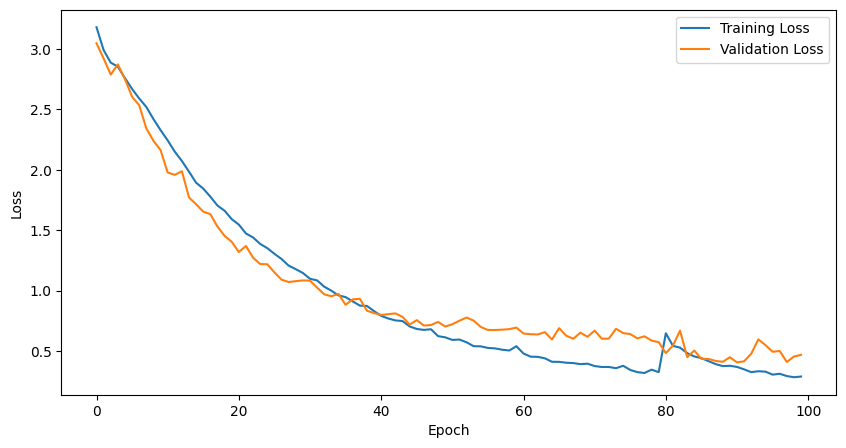

In [27]:
checkpoint_path = '/content/drive/MyDrive/efficientv2_eca_relu_best100.pt'

if os.path.exists(os.path.dirname(checkpoint_path)):
    checkpoint = torch.load(checkpoint_path)
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

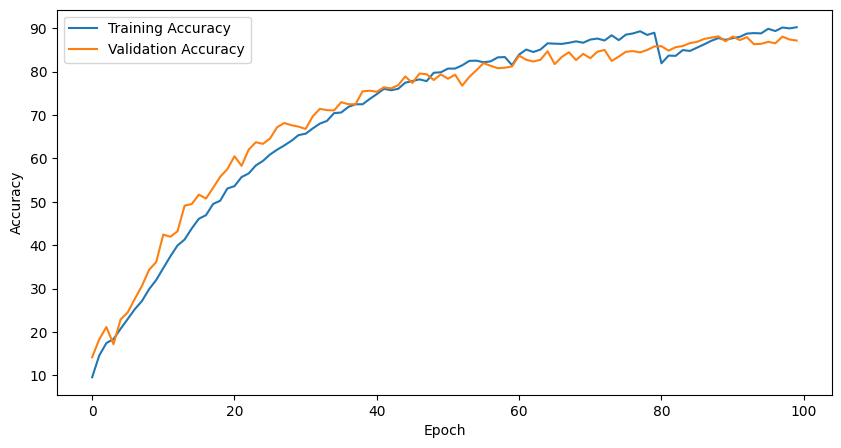

In [28]:
# training, validation loss 시각화 (epoch 40~110)
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# best 파라미터 통한 테스트셋 평가

PATH = '/content/drive/MyDrive/efficientv2_eca_relu_best91.pt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded ckpt from '{PATH}'")
model.to(device)

from sklearn.metrics import accuracy_score

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

<ipython-input-29-cc68d88fe6c3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH)


Loaded ckpt from '/content/drive/MyDrive/efficientv2_eca_relu_best91.pt'
Test Accuracy: 88.47%


In [30]:
image_path = 'data/images/images/aerosol_cans/real_world/Image_1.png'

input_data = Image.open(image_path)
input_data = transform['val'](input_data).unsqueeze(0).to('cuda')
input_data.shape

NUM_ITERS = 100

In [31]:
# EfficientNetV2 with ECA
NUM_ITERS

import torch.profiler

test_model = model.to(device)

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    record_shapes=False,
    profile_memory=False
) as prof:
    with torch.no_grad():
      for _ in range(NUM_ITERS):
        output = test_model(input_data)

print(prof.key_averages().table(sort_by="self_cpu_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        18.64%     488.679ms        18.64%     488.679ms       9.308us       0.000us         0.00%       0.000us       0.000us         52500  
                                aten::cudnn_convolution        17.99%     471.735ms        26.68%     699.552ms      58.296us     371.692ms        57.58%     371.692ms      30.974us         12000  
         